# Transfer Learning with Tensorflow part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extraction. Now it's time to learn a new kind of tranfer learning: fine-tuning.

In [76]:
!nvidia-smi
tf.config.list_physical_devices()

Tue May 14 23:08:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...    Off |   00000000:09:00.0  On |                  N/A |
|  0%   39C    P8             10W /  320W |   14701MiB /  16376MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Creating helper function
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

Always a good idea to use helper functions remember the don't repeat yourself rule

In [77]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-14 23:08:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-14 23:08:31 (20.6 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [78]:
# Import helper functions we're going to use in the notebook
from helper_functions import *


> **Note** if you're running this notebook in Colab, the runtime may time out.  When the runtime runs out colab will delete the helper function so will need to redownload.

## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem(recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [79]:
# Get 10% of training data of 10 classes of Food101
if(not os.path.exists("10_food_classes_10_percent.zip")):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    unzip_data("10_food_classes_10_percent.zip")

In [80]:
# Checkout how many images and sub directories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [81]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [82]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [83]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [84]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [85]:
# See an example of batch of data
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[1.93571434e+01 2.53571434e+01 2.53571434e+01]
   [1.93571434e+01 2.53571434e+01 2.53571434e+01]
   [1.93571434e+01 2.53571434e+01 2.53571434e+01]
   ...
   [8.21377335e+01 9.51479263e+01 1.06642830e+02]
   [7.62397232e+01 8.82397232e+01 1.00239723e+02]
   [7.75714188e+01 8.88571320e+01 1.00857132e+02]]

  [[1.95255108e+01 2.85255108e+01 2.75255108e+01]
   [1.89285717e+01 2.79285717e+01 2.69285717e+01]
   [1.89285717e+01 2.79285717e+01 2.69285717e+01]
   ...
   [9.63877258e+01 1.14214256e+02 1.28142822e+02]
   [9.05713806e+01 1.08285667e+02 1.22214233e+02]
   [9.00918350e+01 1.07806122e+02 1.20540825e+02]]

  [[1.82908154e+01 2.72908154e+01 2.62908154e+01]
   [1.77295914e+01 2.67295914e+01 2.57295914e+01]
   [1.63826542e+01 2.53826542e+01 2.43826542e+01]
   ...
   [1.06806107e+02 1.30571411e+02 1.48831619e+02]
   [1.07428604e+02 1.31056168e+02 1.47428574e+02]
   [1.07790825e+02 1.31433685e+02 1.47647964e+02]]

  ...

  [[1.52571472e+02 1.82132645e+02 2.03637756e+02]
   [1

2024-05-14 23:08:31.562197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model 0: building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility in desiging our models

In [86]:
# Create base model
efficentnet_b0 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    classes=10,
    classifier_activation='softmax',
)

efficentnet_b0.trainable = False

# create inputs for model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
# normalize, needed for some architectures
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = efficentnet_b0(inputs)
print(f"Shape after passing inputs through the base model:{x.shape}")
# average pool the outputs of base model(aggregate most important information, reduce computational expenses)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")
# create output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
# combine inputs and outputs into model
model_0 = tf.keras.Model(inputs,
                   outputs)

model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=["accuracy"])
history_model_0 = model_0.fit(train_data_10_percent,epochs=5,validation_data=test_data,validation_steps=int(0.25*len(test_data)),callbacks=[create_tensorboard_callback(dir_name="transfer learning",experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through the base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer learning/10_percent_feature_extraction/20240514-230832
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 997ms/step - accuracy: 0.3213 - loss: 2.0039 - val_accuracy: 0.7188 - val_loss: 1.2658
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7444 - loss: 1.1680 - val_accuracy: 0.8224 - val_loss: 0.8628
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8220 - loss: 0.8194 - val_accuracy: 0.8273 - val_loss: 0.7245
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8373 - loss: 0.6880 - val_accuracy: 0.8618 - val_loss: 0.6229
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.8851 - loss: 0.5731 - val_accuracy: 0.9118 - val_loss: 0.4610


2024-05-14 23:09:26.252499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-14 23:09:26.252951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [87]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8595 - loss: 0.5682


[0.5638083219528198, 0.8596000075340271]

In [90]:
# check the layers in our base model
for layer_number, layer in enumerate(efficentnet_b0.layers):
    print(f"Layer number:{layer_number} layer name:{layer.name}") 

Layer number:0 layer name:input_layer_44
Layer number:1 layer name:rescaling_66
Layer number:2 layer name:normalization_44
Layer number:3 layer name:stem_conv
Layer number:4 layer name:stem_bn
Layer number:5 layer name:stem_activation
Layer number:6 layer name:block1a_project_conv
Layer number:7 layer name:block1a_project_bn
Layer number:8 layer name:block1a_project_activation
Layer number:9 layer name:block2a_expand_conv
Layer number:10 layer name:block2a_expand_bn
Layer number:11 layer name:block2a_expand_activation
Layer number:12 layer name:block2a_project_conv
Layer number:13 layer name:block2a_project_bn
Layer number:14 layer name:block2b_expand_conv
Layer number:15 layer name:block2b_expand_bn
Layer number:16 layer name:block2b_expand_activation
Layer number:17 layer name:block2b_project_conv
Layer number:18 layer name:block2b_project_bn
Layer number:19 layer name:block2b_drop
Layer number:20 layer name:block2b_add
Layer number:21 layer name:block3a_expand_conv
Layer number:22 l

In [92]:
# summary of base model
efficentnet_b0.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_66        │ (None, None,      │          0 │ input_layer_44[0… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_44    │ (None, None,      │          0 │ rescaling_66[0][… │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_44… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [93]:
model_0.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

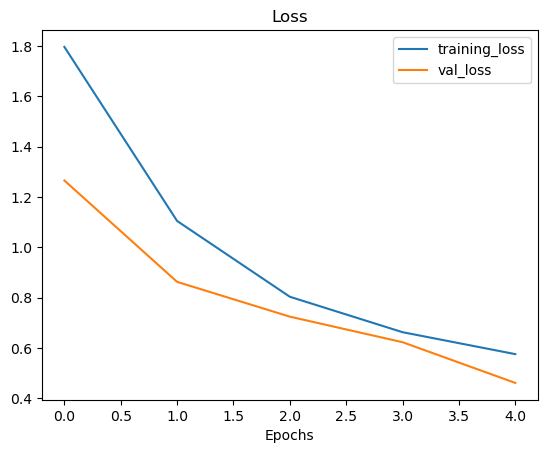

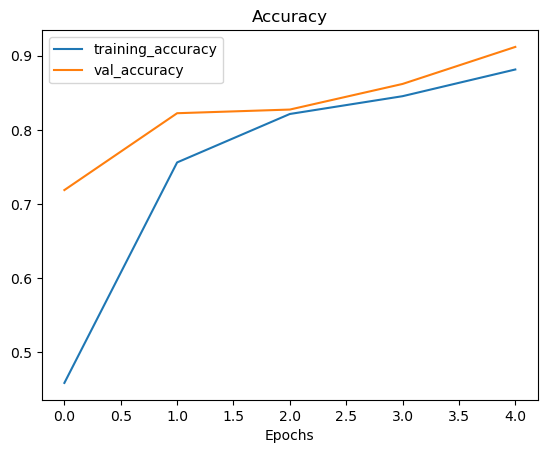

In [94]:
# Check out models training curves
plot_loss_curves(history_model_0)